# Using Tensorflow for forcasting

## Ref URL : https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/timeseries

### For tensorflow I have used the above link for implementing the concept.  Here for each question, I am preparing the dataframe using pandas library. The column names are saved as "timestamp" and "value". Next the dataframe is saved as .csv file and further used. 

### The Dataframe is now read and date parser is used to convert date to timestamp. Next the value passed in the tensor for training and prediction.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os
import sys

import numpy as np
import tensorflow as tf
import pandas as pd
import numpy as np 
from pandas import DataFrame, Series
from matplotlib import pyplot
from datetime import datetime as dt

/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


## Reading saved JSON file for fetched issues

In [2]:
# Read the JSON file into a list of dictionaries

import json
list_of_issues_dict_data = [json.loads(line) for line in open('SPM587SP19issues.json')]

In [3]:
# Create the DataFrame object for the list_of_issues_dict_data object

issues_df = DataFrame(list_of_issues_dict_data)

## Preparing DataFrame object based on labels

In [4]:
# Prepare and Clean the dataframe object

wrangled_issues_df = issues_df[['Author','State','closed_at','created_at','issue_number','labels']]
wrangled_issues_df.loc[0:len(wrangled_issues_df), 'OriginationPhase']= np.NaN
wrangled_issues_df.loc[0:len(wrangled_issues_df),'DetectionPhase']= np.NaN
wrangled_issues_df.loc[0:len(wrangled_issues_df),'Category']= np.NaN
wrangled_issues_df.loc[0:len(wrangled_issues_df),'Priority']= np.NaN
wrangled_issues_df.loc[0:len(wrangled_issues_df),'Status']= np.NaN

for i in range(0, len(wrangled_issues_df)):
    if wrangled_issues_df.iloc[i]['labels']:
        for label in wrangled_issues_df.iloc[i]['labels']:
            label_name= (label.split(':'))[0]
            label_value= (label.split(':'))[1]
            wrangled_issues_df.loc[i, label_name]=label_value
 


In [5]:
# Sanity Check of records
wrangled_issues_df[:5]

,Author,State,closed_at,created_at,issue_number,labels,OriginationPhase,DetectionPhase,Category,Priority,Status,Address,OritinationPhase,Latitude,Longitude,Detection,Origination
0,TSP19SCM781,open,None,2019-04-21,494,"[Category:Enhancement, DetectionPhase:Testing,...",Field,Testing,Enhancement,Critical,Completed,NaN,NaN,NaN,NaN,NaN,NaN
1,TSP19SCM781,open,None,2019-04-21,493,"[Category:Enhancement, DetectionPhase:Design, ...",Design,Design,Enhancement,Major,Completed,NaN,NaN,NaN,NaN,NaN,NaN
2,TSP19SCM781,open,None,2019-04-21,492,"[Category:Inquiry, DetectionPhase:Design, Orig...",Requirements,Design,Inquiry,Major,inProgress,NaN,NaN,NaN,NaN,NaN,NaN
3,DSP19SCM782,open,None,2019-04-21,491,"[Category:Bug, DetectionPhase:Field, Originati...",Field,Field,Bug,Major,pendingReview,NaN,NaN,NaN,NaN,NaN,NaN
4,DSP19SCM782,open,None,2019-04-21,490,"[Category:Bug, DetectionPhase:Design, Originat...",Testing,Design,Bug,High,pendingReview,NaN,NaN,NaN,NaN,NaN,NaN


## This block is used for Calling Auto Regressive Model for training when there is less no of records i.e around 5.

In [6]:
# This block is used for Calling Auto Regressive Model for training when there is less no of records.
def ar_train_and_predict_less_records(csv_file_name):
  # An autoregressive model, with periodicity handled as a time-based
  # regression. Note that this requires windows of size 16 (input_window_size +
  # output_window_size) for training.
    ar = tf.contrib.timeseries.ARRegressor(
        periodicities=200, input_window_size=2, output_window_size=2,num_features=1,
      # Use the (default) normal likelihood loss to adaptively fit the
      # variance. SQUARED_LOSS overestimates variance when there are trends in
      # the series.
        loss=tf.contrib.timeseries.ARModel.NORMAL_LIKELIHOOD_LOSS)
    return train_and_predict_less_records(ar, csv_file_name, training_steps=1000)

## This block is used for Calling Auto Regressive Model for training when there is more no of records

In [7]:
# This block is used for Calling Auto Regressive Model for training when there is more no of records.
def ar_train_and_predict(csv_file_name):
  # An autoregressive model, with periodicity handled as a time-based
  # regression. Note that this requires windows of size 16 (input_window_size +
  # output_window_size) for training.
    ar = tf.contrib.timeseries.ARRegressor(
        periodicities=200, input_window_size=10, output_window_size=6,num_features=1,
      # Use the (default) normal likelihood loss to adaptively fit the
      # variance. SQUARED_LOSS overestimates variance when there are trends in
      # the series.
        loss=tf.contrib.timeseries.ARModel.NORMAL_LIKELIHOOD_LOSS)
    return train_and_predict(ar, csv_file_name, training_steps=1000)

## Function used for plotting the graph

In [8]:
# This method is used for plotting the graph
def make_plot(name, training_times, observed, all_times, mean,
              upper_limit, lower_limit):
    """Plot a time series in a new figure."""
    pyplot.figure()
    pyplot.figure(figsize=(15, 5))
    pyplot.plot(training_times, observed, "b", label="training series")
    pyplot.plot(all_times, mean, "r", label="forecast")
    pyplot.plot(all_times, upper_limit, "g", label="forecast upper bound")
    pyplot.plot(all_times, lower_limit, "g", label="forecast lower bound")
    pyplot.fill_between(all_times, lower_limit, upper_limit, color="grey",
                      alpha="0.2")
    pyplot.axvline(training_times[-1], color="k", linestyle="--")
    pyplot.xlabel("time")
    pyplot.ylabel("observations")
    pyplot.legend(loc=0)
    pyplot.title(name)

## This method is used for convering date into timestamp

In [9]:
def date_parser(date_str):
    return dt.strptime(date_str, "%Y-%m-%d").strftime("%s")

## This block is used for training and predicting for records in batch size 16 and more i.e. for more records.

In [10]:
def train_and_predict(estimator, csv_file_name, training_steps):
    """A simple example of training and predicting."""
    ### Read data in the default "time,value" CSV format with no header
    #reader = tf.contrib.timeseries.CSVReader(csv_file_name)
    
    data = pd.read_csv(csv_file_name
                       , header=0
                       , parse_dates=['timestamp']
                       , date_parser=date_parser)

    data['timestamp'] = data['timestamp'].apply(lambda x: int(x))
    reader = tf.contrib.timeseries.NumpyReader(data={tf.contrib.timeseries.TrainEvalFeatures.TIMES: data['timestamp'].values, tf.contrib.timeseries.TrainEvalFeatures.VALUES : data['value'].values})
    print('Data Converted to Reader')
    # Set up windowing and batching for training
    train_input_fn = tf.contrib.timeseries.RandomWindowInputFn(
      reader, batch_size=16, window_size=16)
    # Fit model parameters to data
    estimator.train(input_fn=train_input_fn, steps=training_steps)
    # Evaluate on the full dataset sequentially, collecting in-sample predictions
    # for a qualitative evaluation. Note that this loads the whole dataset into
    # memory. For quantitative evaluation, use RandomWindowChunker.
    evaluation_input_fn = tf.contrib.timeseries.WholeDatasetInputFn(reader)
    evaluation = estimator.evaluate(input_fn=evaluation_input_fn, steps=1)
    # Predict starting after the evaluation
    (predictions,) = tuple(estimator.predict(
      input_fn=tf.contrib.timeseries.predict_continuation_input_fn(
          evaluation, steps=200)))
    times = evaluation["times"][0]
    observed = evaluation["observed"][0, :, 0]
    mean = np.squeeze(np.concatenate(
      [evaluation["mean"][0], predictions["mean"]], axis=0))
    variance = np.squeeze(np.concatenate(
      [evaluation["covariance"][0], predictions["covariance"]], axis=0))
    all_times = np.concatenate([times, predictions["times"]], axis=0)
    upper_limit = mean + np.sqrt(variance)
    lower_limit = mean - np.sqrt(variance)
    return times, observed, all_times, mean, upper_limit, lower_limit


## This block is used for training and predicting for records in batch size 4 i.e. for less no of records.

In [11]:
def train_and_predict_less_records(estimator, csv_file_name, training_steps):
    """A simple example of training and predicting."""
    ### Read data in the default "time,value" CSV format with no header
    #reader = tf.contrib.timeseries.CSVReader(csv_file_name)
    
    data = pd.read_csv(csv_file_name
                       , header=0
                       , parse_dates=['timestamp']
                       , date_parser=date_parser)

    data['timestamp'] = data['timestamp'].apply(lambda x: int(x))
    reader = tf.contrib.timeseries.NumpyReader(data={tf.contrib.timeseries.TrainEvalFeatures.TIMES: data['timestamp'].values, tf.contrib.timeseries.TrainEvalFeatures.VALUES : data['value'].values})
    print('Data Converted to Reader')
    # Set up windowing and batching for training
    train_input_fn = tf.contrib.timeseries.RandomWindowInputFn(
      reader, batch_size=4, window_size=4)
    # Fit model parameters to data
    estimator.train(input_fn=train_input_fn, steps=training_steps)
    # Evaluate on the full dataset sequentially, collecting in-sample predictions
    # for a qualitative evaluation. Note that this loads the whole dataset into
    # memory. For quantitative evaluation, use RandomWindowChunker.
    evaluation_input_fn = tf.contrib.timeseries.WholeDatasetInputFn(reader)
    evaluation = estimator.evaluate(input_fn=evaluation_input_fn, steps=1)
    # Predict starting after the evaluation
    (predictions,) = tuple(estimator.predict(
      input_fn=tf.contrib.timeseries.predict_continuation_input_fn(
          evaluation, steps=200)))
    times = evaluation["times"][0]
    observed = evaluation["observed"][0, :, 0]
    mean = np.squeeze(np.concatenate(
      [evaluation["mean"][0], predictions["mean"]], axis=0))
    variance = np.squeeze(np.concatenate(
      [evaluation["covariance"][0], predictions["covariance"]], axis=0))
    all_times = np.concatenate([times, predictions["times"]], axis=0)
    upper_limit = mean + np.sqrt(variance)
    lower_limit = mean - np.sqrt(variance)
    return times, observed, all_times, mean, upper_limit, lower_limit


## 6.1 The day of the week maximum number of issues created

/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_summary_steps': 100, '_is_chief': True, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': None, '_model_dir': '/var/folders/w5/4tlh63dx7yb713_mjd3r3bph0000gn/T/tmp0vqc3612', '_task_type': 'worker', '_task_id': 0, '_num_worker_replicas': 1, '_save_checkpoints_secs': 600, '_service': None, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_master': '', '_tf_random_seed': None, '_session_config': None, '_device_fn': None, '_global_id_in_cluster': 0, '_evaluation_master': '', '_train_distribute': None, '_log_step_count_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c2947ffd0>}
Data Converted to Reader
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:

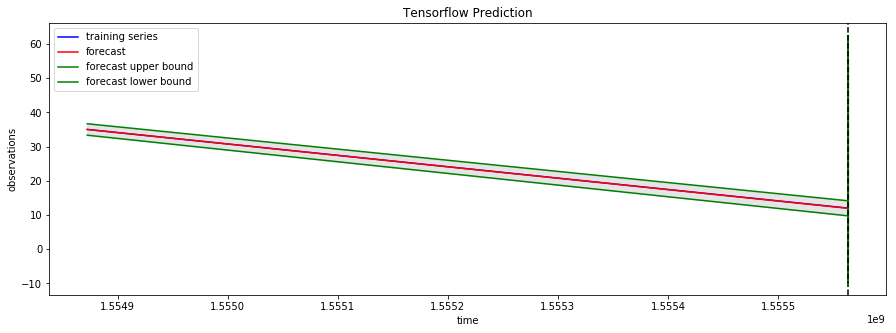

In [12]:
# The day of the week maximum number of issues created
df = wrangled_issues_df.groupby('created_at')['created_at']
df_new = df.describe()
s1 = pd.Series(df_new['top'], name='date')

#Creating a new dataframe for capturing copy of dates
df_new = pd.concat([df_new, s1], axis=1)
pdf = pd.DataFrame(['ds','ds_actual','y'])
pdf = df_new[['top','date','count']]
pdf.columns = ['ds','ds_actual','y']

#Generating Monday for any given date and grouping by using the week
pdf['ds'] = pd.to_datetime(pdf['ds']) - pd.to_timedelta(7, unit='d')
df_weekly_max_count = pdf.reset_index().groupby(
    [pd.Grouper(key='ds', freq='W-MON')]).apply(lambda x: x.loc[x.y == x.y.max(),['ds_actual','y']])

# Again fetching the grouped data and storing it into a new dataframe that is used for plotting
df_forPrediction = pd.DataFrame(['ds','y'])
df_forPrediction = df_weekly_max_count[['ds_actual','y']]
df_forPrediction.columns = ['timestamp','value']
export_csv = df_forPrediction.to_csv (r'./export_dataframe.csv', index = None, header=True) 
make_plot("Tensorflow Prediction", *ar_train_and_predict_less_records('./export_dataframe.csv'))
pyplot.show()



## 6.2 The day of the week maximum number of issues closed

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_summary_steps': 100, '_is_chief': True, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': None, '_model_dir': '/var/folders/w5/4tlh63dx7yb713_mjd3r3bph0000gn/T/tmpftj5jpek', '_task_type': 'worker', '_task_id': 0, '_num_worker_replicas': 1, '_save_checkpoints_secs': 600, '_service': None, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_master': '', '_tf_random_seed': None, '_session_config': None, '_device_fn': None, '_global_id_in_cluster': 0, '_evaluation_master': '', '_train_distribute': None, '_log_step_count_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c2b0a2208>}
Data Converted to Reader
INFO:tensorflow:Calling model_fn.


/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/w5/4tlh63dx7yb713_mjd3r3bph0000gn/T/tmpftj5jpek/model.ckpt.
INFO:tensorflow:loss = 1.7153906, step = 1
INFO:tensorflow:global_step/sec: 253.284
INFO:tensorflow:loss = 0.49350548, step = 101 (0.396 sec)
INFO:tensorflow:global_step/sec: 666.715
INFO:tensorflow:loss = 0.5465201, step = 201 (0.150 sec)
INFO:tensorflow:global_step/sec: 627.692
INFO:tensorflow:loss = -1.2174665, step = 301 (0.159 sec)
INFO:tensorflow:global_step/sec: 777.926
INFO:tensorflow:loss = -1.5434887, step = 401 (0.130 sec)
INFO:tensorflow:global_step/sec: 920.819
INFO:tensorflow:loss = -1.9745826, step = 501 (0.107 sec)
INFO:tensorflow:global_step/sec: 977.965
INFO:tensorflow:loss = -0.9868408, step = 601 (0.102 sec)
INFO:tensorflow:global_step/sec: 960.164
I

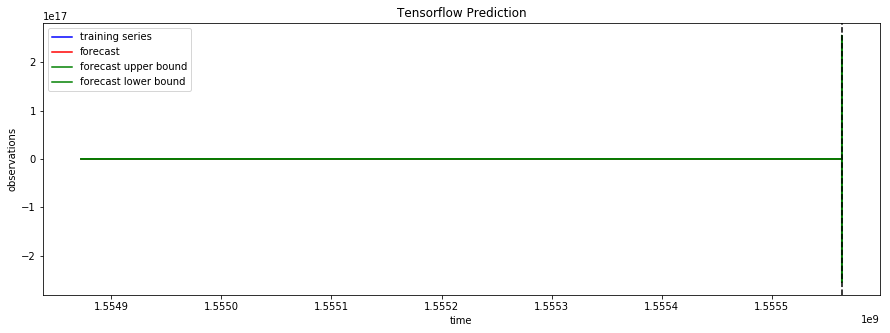

In [13]:
#The day of the week maximum number of issues closed
df_closed = wrangled_issues_df[(wrangled_issues_df['State'] == 'closed')]
df_closed_gby = df_closed.groupby(['closed_at','State'])['closed_at']

df_new = df_closed_gby.describe()
s1 = pd.Series(df_new['top'], name='date')

#Creating a new dataframe for capturing copy of dates
df_new = pd.concat([df_new, s1], axis=1)
pdf = pd.DataFrame(['ds','ds_actual','y'])
pdf = df_new[['top','date','count']]
pdf.columns = ['ds','ds_actual','y']

#Generating Monday for any given date and grouping by using the week
pdf['ds'] = pd.to_datetime(pdf['ds']) - pd.to_timedelta(7, unit='d')
df_weekly_max_count = pdf.reset_index().groupby(
    [pd.Grouper(key='ds', freq='W-MON')]).apply(lambda x: x.loc[x.y == x.y.max(),['ds_actual','y']])

# Again fetching the grouped data and storing it into a new dataframe that is used for plotting
df_forPrediction = pd.DataFrame(['ds','y'])
df_forPrediction = df_weekly_max_count[['ds_actual','y']]
df_forPrediction.columns = ['timestamp','value']
df_forPrediction.columns = ['timestamp','value']
export_csv = df_forPrediction.to_csv (r'./export_dataframe.csv', index = None, header=True)
make_plot("Tensorflow Prediction", *ar_train_and_predict_less_records('./export_dataframe.csv'))
pyplot.show()


## 6.3 Plot the created issues forecast  using fetched dataframe.

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_summary_steps': 100, '_is_chief': True, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': None, '_model_dir': '/var/folders/w5/4tlh63dx7yb713_mjd3r3bph0000gn/T/tmpfyv9thm1', '_task_type': 'worker', '_task_id': 0, '_num_worker_replicas': 1, '_save_checkpoints_secs': 600, '_service': None, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_master': '', '_tf_random_seed': None, '_session_config': None, '_device_fn': None, '_global_id_in_cluster': 0, '_evaluation_master': '', '_train_distribute': None, '_log_step_count_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c2afffc18>}
Data Converted to Reader
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:

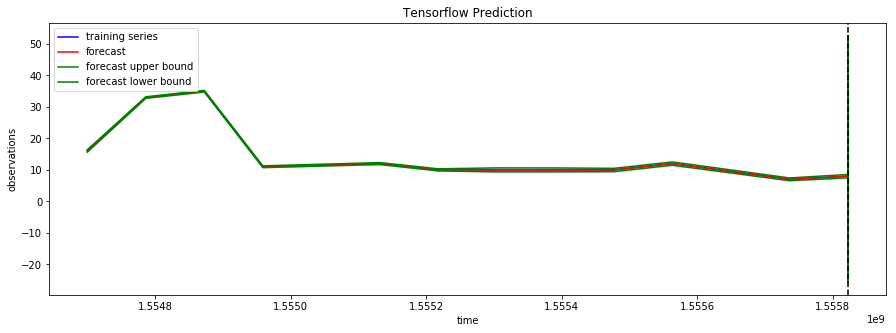

In [14]:
#Plot the created issues forecast by calling the Prophet.plot method and passing in your forecast dataframe.

df = wrangled_issues_df.groupby('created_at')['created_at']
#print(df.count().idxmax())
df_new = df.describe()
df_new['count']
df_new['top']
tdf = pd.DataFrame()
tdf = df_new[['top','count']]
tdf.columns = ['timestamp','value']
#tdf['ts'] = tdf.datetime.values.astype(np.int64)
export_csv = tdf.to_csv (r'./export_dataframe.csv', index = None, header=True) 

#make_plot("Structural ensemble",*structural_ensemble_train_and_predict('./export_dataframe.csv'))
make_plot("Tensorflow Prediction", *ar_train_and_predict('./export_dataframe.csv'))
pyplot.show()

## 6.4 Plot the closed issues forecast on the received data.

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_summary_steps': 100, '_is_chief': True, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': None, '_model_dir': '/var/folders/w5/4tlh63dx7yb713_mjd3r3bph0000gn/T/tmpu5nrlm3g', '_task_type': 'worker', '_task_id': 0, '_num_worker_replicas': 1, '_save_checkpoints_secs': 600, '_service': None, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_master': '', '_tf_random_seed': None, '_session_config': None, '_device_fn': None, '_global_id_in_cluster': 0, '_evaluation_master': '', '_train_distribute': None, '_log_step_count_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c2999af28>}
Data Converted to Reader
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:

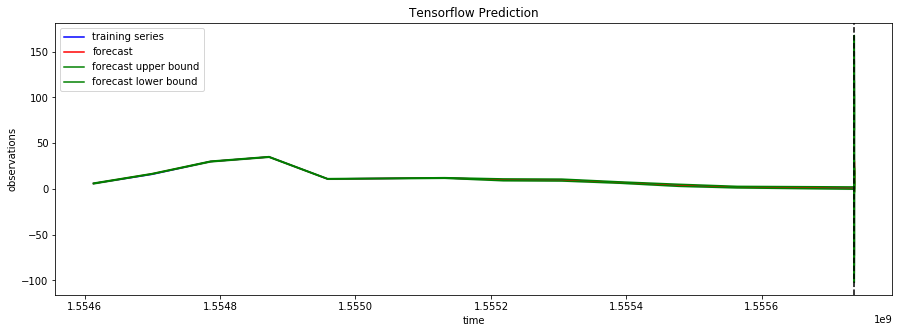

In [15]:
#Plot the closed issues forecast; use the Prophet.plot_components method. 
# By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series.
# If you include holidays, you’ll see those here, too.

df_closed = wrangled_issues_df[(wrangled_issues_df['State'] == 'closed')]
df_closed_gby = df_closed.groupby(['created_at','State'])['created_at']
#df = wrangled_issues_df.groupby('created_at')['created_at']
#print(df.count().idxmax())
df_new = df_closed_gby.describe()
df_new['count']
df_new['top']
tdf = pd.DataFrame()
tdf = df_new[['top','count']]
tdf.columns = ['timestamp','value']
#tdf['ts'] = tdf.datetime.values.astype(np.int64)
export_csv = tdf.to_csv (r'./export_dataframe.csv', index = None, header=True) 

#make_plot("Structural ensemble",*structural_ensemble_train_and_predict('./export_dataframe.csv'))
make_plot("Tensorflow Prediction", *ar_train_and_predict('./export_dataframe.csv'))
pyplot.show()

## Reading saved JSON file for fetched pulls

In [16]:
# Read the JSON file into a list of dictionaries

import json
list_of_pulls_dict_data = [json.loads(line) for line in open('SPM587SP19pulls.json')]

# Create the DataFrame object for the list_of_issues_dict_data object

pulls_df = DataFrame(list_of_pulls_dict_data)

In [17]:
# Sanity Check
pulls_df[:5]

,Author,State,closed_at,created_at,issue_number,labels
0,JSP19SCM03G,closed,2019-04-20,2019-04-20,481,[]
1,YSP19SCM26X,closed,2019-04-19,2019-04-19,478,[]
2,YSP19SCM26X,closed,2019-04-18,2019-04-18,466,[]
3,SSP19SCM81Y,closed,2019-04-20,2019-04-13,424,[]
4,JSP19SCM33G,closed,2019-04-11,2019-04-11,411,[]


## 6.5 Plot the pulls forecast based on the received data. 

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_summary_steps': 100, '_is_chief': True, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': None, '_model_dir': '/var/folders/w5/4tlh63dx7yb713_mjd3r3bph0000gn/T/tmpgbjd9ymz', '_task_type': 'worker', '_task_id': 0, '_num_worker_replicas': 1, '_save_checkpoints_secs': 600, '_service': None, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_master': '', '_tf_random_seed': None, '_session_config': None, '_device_fn': None, '_global_id_in_cluster': 0, '_evaluation_master': '', '_train_distribute': None, '_log_step_count_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c2b12a898>}
Data Converted to Reader
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:

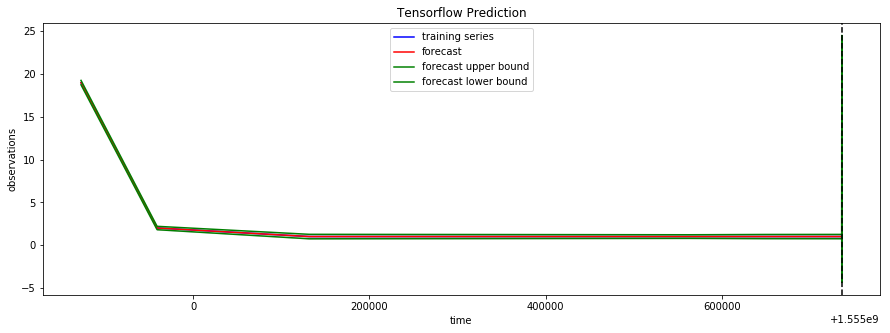

In [18]:
# Plot the pulls forecast; use the Prophet.plot_components method. 
# By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. 
# If you include holidays, you’ll see those here, too.

df_pulls_gby = pulls_df.groupby('created_at')['created_at']
#df = wrangled_issues_df.groupby('created_at')['created_at']
#print(df.count().idxmax())
df_new = df_pulls_gby.describe()
df_new['count']
df_new['top']
tdf = pd.DataFrame()
tdf = df_new[['top','count']]
tdf.columns = ['timestamp','value']
#tdf['ts'] = tdf.datetime.values.astype(np.int64)
export_csv = tdf.to_csv (r'./export_dataframe.csv', index = None, header=True) 

#make_plot("Structural ensemble",*structural_ensemble_train_and_predict('./export_dataframe.csv'))
make_plot("Tensorflow Prediction", *ar_train_and_predict('./export_dataframe.csv'))
pyplot.show()

## Reading saved JSON file for fetched commits

In [19]:
# Read the JSON file into a list of dictionaries

import json

file = open("SPM587SP19commits.json", "r") 
list_of_commit_dict_data = [json.loads(line) for line in open('SPM587SP19commits.json')]
commits_df = DataFrame(list_of_commit_dict_data)

In [20]:
# Sanity Check
commits_df[:5]

,created_at
0,2019-04-20
1,2019-04-20
2,2019-04-20
3,2019-04-20
4,2019-04-20


## 6.6 Plot the commits forecast based on received data.


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_summary_steps': 100, '_is_chief': True, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': None, '_model_dir': '/var/folders/w5/4tlh63dx7yb713_mjd3r3bph0000gn/T/tmpq44cufms', '_task_type': 'worker', '_task_id': 0, '_num_worker_replicas': 1, '_save_checkpoints_secs': 600, '_service': None, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_master': '', '_tf_random_seed': None, '_session_config': None, '_device_fn': None, '_global_id_in_cluster': 0, '_evaluation_master': '', '_train_distribute': None, '_log_step_count_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c29e50ef0>}
Data Converted to Reader
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:

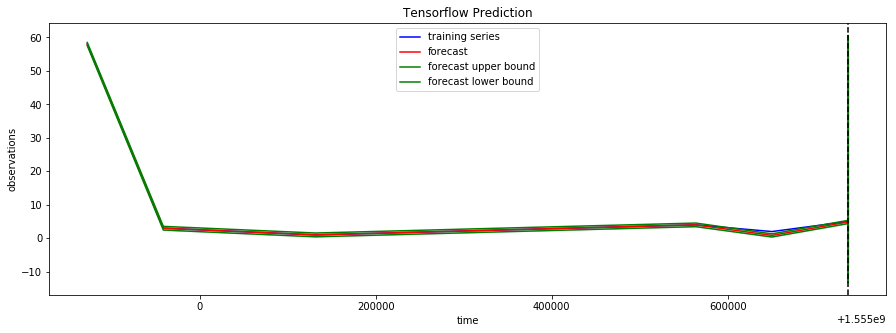

In [22]:
# Plot the commits forecast; use the Prophet.plot_components method. 
# By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. 
# If you include holidays, you’ll see those here, too.

df_commits_gby = commits_df.groupby('created_at')['created_at']
df_new = df_commits_gby.describe()
df_new['count']
df_new['top']
tdf = pd.DataFrame()
tdf = df_new[['top','count']]
tdf.columns = ['timestamp','value']
export_csv = tdf.to_csv (r'./export_dataframe.csv', index = None, header=True) 

make_plot("Tensorflow Prediction", *ar_train_and_predict('./export_dataframe.csv'))
pyplot.show()